In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import math
from itertools import product
import numpy as np

In [2]:
df = pd.read_csv("/content/HSG-Historical-Data.csv", parse_dates=['Date'], index_col='Date', sep=',')
df = df.sort_index(ascending=True)
print(df.head())

              Price     Open     High      Low    Vol. Change %
Date                                                           
2019-03-01  6,100.0  5,896.6  6,100.0  5,772.0  11.57M    6.77%
2019-03-04  6,526.3  6,421.4  6,526.3  6,231.1  14.78M    6.99%
2019-03-05  6,500.1  6,559.1  6,821.5  6,401.7  16.02M   -0.40%
2019-03-06  6,277.1  6,473.8  6,559.1  6,106.5  15.89M   -3.43%
2019-03-07  6,034.4  6,237.7  6,277.1  6,034.4   9.73M   -3.87%


In [3]:
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [4]:
df['Vol.'] = df['Vol.'].apply(lambda x: float(x.replace('M', '').replace('K', '')) * (1e6 if 'M' in x else 1e3))

df['Change %'] = df['Change %'].str.replace('%', '')
df['Change %'] = df['Change %'].str.replace(',', '.').astype(float) / 100
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df.dropna(inplace=True)

print(df.dtypes)
df.head()

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,6100.0,5896.6,6100.0,5772.0,11570000.0,0.0677
2019-03-04,6526.3,6421.4,6526.3,6231.1,14780000.0,0.0699
2019-03-05,6500.1,6559.1,6821.5,6401.7,16020000.0,-0.0040
2019-03-06,6277.1,6473.8,6559.1,6106.5,15890000.0,-0.0343
2019-03-07,6034.4,6237.7,6277.1,6034.4,9730000.0,-0.0387


Ma trận tương quan:
             Price      Open      High       Low      Vol.  Change %
Price     1.000000  0.998482  0.999352  0.999290  0.288219  0.007429
Open      0.998482  1.000000  0.999443  0.999410  0.284490 -0.035665
High      0.999352  0.999443  1.000000  0.999326  0.293487 -0.017538
Low       0.999290  0.999410  0.999326  1.000000  0.278660 -0.016833
Vol.      0.288219  0.284490  0.293487  0.278660  1.000000  0.069559
Change %  0.007429 -0.035665 -0.017538 -0.016833  0.069559  1.000000


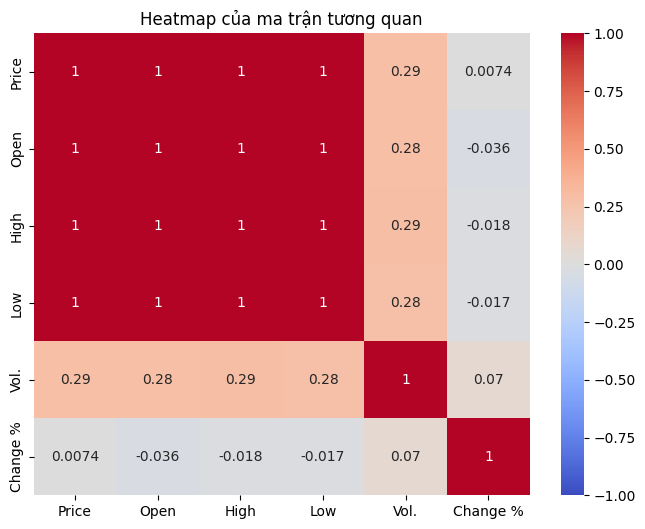

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame(df)

corr_matrix = data.corr()

print("Ma trận tương quan:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap của ma trận tương quan')
plt.show()

In [6]:
df = df[["Price", "Open", "High", "Low"]]
df.head()

,Price,Open,High,Low
Date,,,,
2019-03-01,6100.0,5896.6,6100.0,5772.0
2019-03-04,6526.3,6421.4,6526.3,6231.1
2019-03-05,6500.1,6559.1,6821.5,6401.7
2019-03-06,6277.1,6473.8,6559.1,6106.5
2019-03-07,6034.4,6237.7,6277.1,6034.4


In [7]:
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]
train_df = train
train = np.asarray(train)

print(len(df))
print(len(train))
print(len(test))

1313
919
394


In [8]:
#Find best AR and MA for VARMA modeling by evalute AIC.
p_values = range(1, 5)
q_values = range(1, 5)

best_aic = np.inf
best_order = (0, 0)

for p in p_values:
    for q in q_values:
        try:
            model = VARMAX(data, order=(p, q))
            model_fit = model.fit(disp=False)

            aic = model_fit.aic

            print(f'VARMA({p}, {q}) - AIC: {aic}')

            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
        except Exception as e:
            print(f'VARMA({p}, {q}) - Error: {e}')

print(f'Best VARMA order: {best_order} - AIC: {best_aic}')

VARMA(1, 1) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.21077e-29): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.24075e-27): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estima

KeyboardInterrupt: 

In [9]:
model = VARMAX(train, order=(3, 1))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                              Statespace Model Results                              
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                  919
Model:                           VARMA(3,1)   Log Likelihood              -25584.932
                                + intercept   AIC                          51325.864
Date:                      Tue, 18 Jun 2024   BIC                          51702.081
Time:                              17:30:43   HQIC                         51469.437
Sample:                                   0                                         
                                      - 919                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):         0.00, 0.00, 0.00, 0.01   Jarque-Bera (JB):   404.50, 1769.77, 1006.80, 681.08
Prob(Q):                    0.95, 0.95, 0.96, 0.92   Prob(JB):                     0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H):

In [16]:
forecast = model_fit.forecast(steps=len(test))

forecast = pd.DataFrame(forecast, index=test.index, columns=test.columns)

print(forecast.head())

                   Price          Open          High           Low
Date                                                              
2022-10-31  11514.910034  11490.344493  11904.575642  11107.276402
2022-11-01  11673.093964  11534.220950  11946.284810  11282.065793
2022-11-02  11623.194347  11660.392204  11990.330499  11387.954564
2022-11-03  11598.922729  11587.680364  11935.429568  11336.450643
2022-11-04  11585.312239  11586.196073  11909.253484  11331.470983


In [17]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

mae = mean_absolute_error(test["Price"], forecast["Price"])
mape = mean_absolute_percentage_error(test["Price"], forecast["Price"])
rmse = np.sqrt(mean_squared_error(test["Price"], forecast["Price"]))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 5345.893577548557
Mean Absolute Percentage Error (MAPE): 0.2844887398573713
Root Mean Squared Error (RMSE): 6131.725324679745


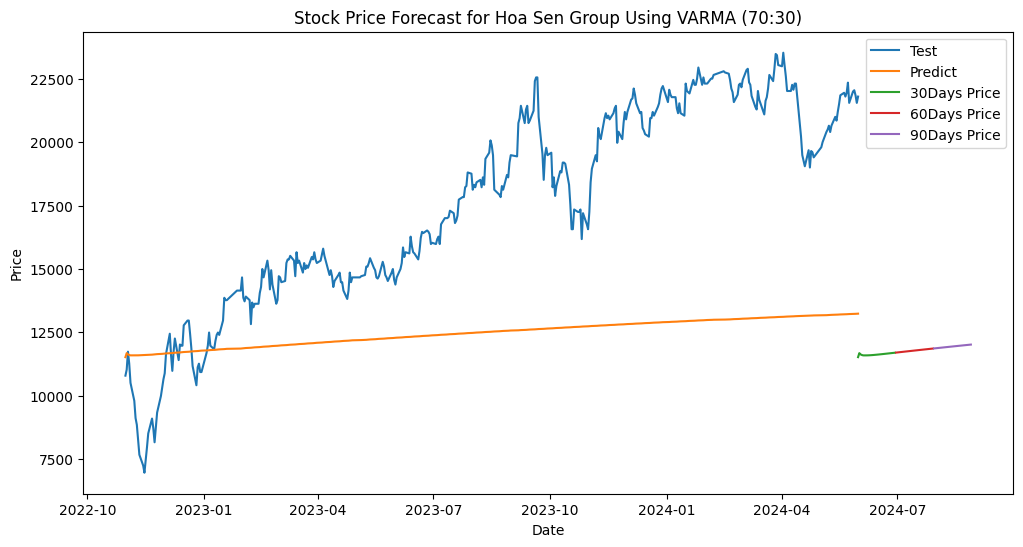

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

forecast_horizon = 90
next_90_days_forecast = model_fit.forecast(steps=forecast_horizon)
forecast_df_90 = pd.DataFrame(next_90_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)

forecast_horizon = 60
next_60_days_forecast = model_fit.forecast(steps=forecast_horizon)
forecast_df_60 = pd.DataFrame(next_60_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)

forecast_horizon = 30
next_30_days_forecast = model_fit.forecast(steps=forecast_horizon)
forecast_df_30 = pd.DataFrame(next_30_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)

plt.plot(test.index, test["Price"], label='Test')

plt.plot(test.index, forecast["Price"], label='Predict')

plt.plot(forecast_df_30.index, forecast_df_30["Price"], label='30Days Price')

filtered_df_60 = forecast_df_60.iloc[30:60]

plt.plot(filtered_df_60.index, filtered_df_60["Price"], label='60Days Price')

filtered_df_90 = forecast_df_90.iloc[60:90]

plt.plot(filtered_df_90.index, filtered_df_90["Price"], label='90Days Price')

plt.title('Stock Price Forecast for Hoa Sen Group Using VARMA (70:30)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

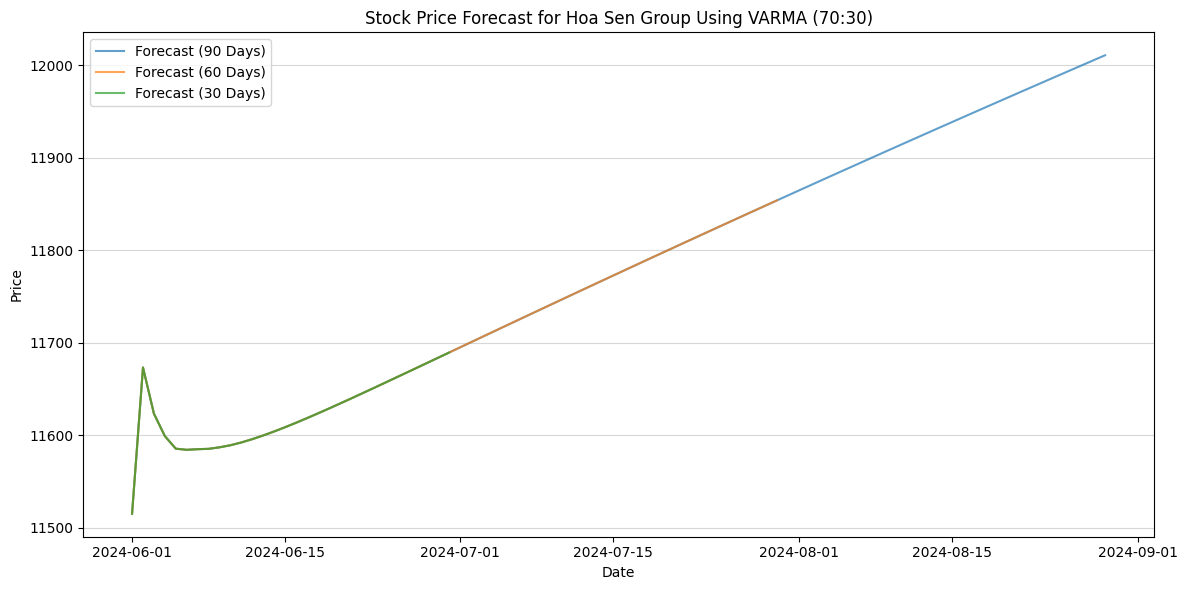

In [19]:
# Forecasting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

forecast_horizons = [90, 60, 30]
forecast_dfs = {}

for horizon in forecast_horizons:
    forecast = model_fit.forecast(steps=horizon)
    forecast_df = pd.DataFrame(
        forecast,
        index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=horizon, freq='D'),
        columns=df.columns
    )
    forecast_dfs[horizon] = forecast_df

for horizon, forecast_df in forecast_dfs.items():
    plt.plot(forecast_df.index, forecast_df["Price"],
             label=f'Forecast ({horizon} Days)', alpha=0.7)

plt.title('Stock Price Forecast for Hoa Sen Group Using VARMA (70:30)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()
